In [1]:
import ee
import pandas as pd
import geemap
import numpy as no

from pprint import  pprint

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ee.Initialize()

##### Define the basic parameters

In [3]:
region_en = 'xinan'
region_cn = '西南'

In [4]:
# import north_china_plain boundary
Region =  ee.FeatureCollection("users/wangjinzhulala/China_built_up/01_Boundary_shp/China_zone")\
            .filterMetadata('NAME1','equals',region_cn)

In [8]:
mask_years = [2016,2019]
original_range = ['2014_2016','2017_2019']

In [9]:
validation_path = 'users/wangjinzhulala/China_built_up/04_sample_train_test_split'
validation_sample = [ee.FeatureCollection(f"{validation_path}/Grid_select_{region_en}_{year}") for year in original_range]

In [12]:
img_path = 'users/wangjinzhulala/China_built_up/05_primary_classification'

##### compute the best urban-percentage of Sentinel-landcover dataset

In [14]:
sentine_urban = [ee.Image(f'COPERNICUS/Landcover/100m/Proba-V-C3/Global/{year}').select("urban-coverfraction") 
                 for year in mask_years]

In [19]:
# iterate each percentage to get the accuracy 

pct_acc = {}

for year,urban,sample in zip(mask_years,sentine_urban,validation_sample):
    
    validation_size = sample.size().getInfo()
    
    for i in range(5,100,5):
        
        img = urban.gte(i)
        stats = img.sampleRegions(collection = sample,
                                  properties = ['Built'],
                                  scale=100, 
                                  geometries = True)

        agree_num = stats.filter(ee.Filter.equals('Built',None,'urban-coverfraction')).size().getInfo()
        acc = round(agree_num/validation_size*100,2)

        pct_acc[(year,i)] = [acc]

        print(f'{year}_{i}-->{acc}')

2016_5-->97.76
2016_10-->97.76
2016_15-->98.08
2016_20-->98.08
2016_25-->98.08
2016_30-->98.08
2016_35-->98.08
2016_40-->98.08
2016_45-->98.08
2016_50-->98.08
2016_55-->97.76
2016_60-->97.76
2016_65-->97.44
2016_70-->97.12
2016_75-->97.12
2016_80-->96.47
2016_85-->96.47
2016_90-->95.83
2016_95-->94.55
2019_5-->97.12
2019_10-->96.79
2019_15-->97.12
2019_20-->97.12
2019_25-->97.12
2019_30-->97.12
2019_35-->97.12
2019_40-->97.12
2019_45-->97.12
2019_50-->97.12
2019_55-->96.79
2019_60-->96.79
2019_65-->96.47
2019_70-->96.15
2019_75-->95.83
2019_80-->95.51
2019_85-->95.51
2019_90-->94.87
2019_95-->93.91


In [20]:
accuracy_df = pd.DataFrame(pct_acc).T
accuracy_df.reset_index(inplace=True)
accuracy_df.columns = ['year','mask_val','accuracy']


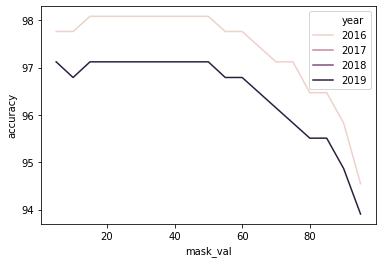

In [21]:
sns.lineplot(data=accuracy_df,x='mask_val',y='accuracy',hue='year')

In [22]:
threshold = 30

##### use the sentinel-urban as a binary mask to erase the incorect pixel in the classification of [2014-2016, 2017-2019]

In [12]:
# fetch the original img

original_maps = []

for year in original_range:
    
    imgs = [ee.Image(f"{img_path}/Spectrum_Normalize_Fourier_Terrain_Meterology_{region_en}_{year}_{seed}") 
            for seed in range(10)]
    
    ten_folds_check = ee.ImageCollection(imgs).sum().gte(4)
    
    original_maps.append(ten_folds_check)


# use the threshold to construct the urban mask
urban_masks = [img.gte(threshold).clip(Region) for img in sentine_urban]

# use the mask to update original img
clasification_update = [original.multiply(mask) for original,mask in zip(original_maps,urban_masks)]
clasification_update[0] = clasification_update[0].multiply(clasification_update[1])

In [13]:
Map = geemap.Map()

Map.add_basemap('HYBRID')

Map.addLayer(original_maps[0],         {'min':0,'max':1},'original_2014_2016')
Map.addLayer(ee.Image(urban_masks[0]), {'min':0,'max':1},'mask_2016')
Map.addLayer(clasification_update[0],  {'min':0,'max':1},'update_2014_2016')

Map.addLayer(original_maps[1],         {'min':0,'max':1},'original_2017_2019')
Map.addLayer(ee.Image(urban_masks[1]), {'min':0,'max':1},'mask_2019')
Map.addLayer(clasification_update[1],  {'min':0,'max':1},'update_2017_2019')

Map.centerObject(Region,10)
Map

Map(center=[30.448045813339593, 118.03734052280193], controls=(WidgetControl(options=['position'], widget=HBox…

##### Export the updated img

In [51]:
# export

for year,img in zip(original_range,clasification_update):
    
    name = f'Sentinel_update_{region_en}_{year}'
    
    # construct a task
    task = ee.batch.Export.image.toAsset(    
                                            image= img,
                                            description=name,
                                            assetId=f'{img_path}/{name}',
                                            region=Region.geometry().bounds(),
                                            scale=30,
                                            maxPixels=int(1e13)
    )

    task.start()

    # print out the process
    print(f'{name} has been exported!')

Sentinel_update_zhongnan_2014_2016 has been exported!
Sentinel_update_zhongnan_2017_2019 has been exported!
